In [106]:
from matplotlib import pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from datetime import datetime

Чтение датасета в DataFrame и нормализация данных

In [107]:
def load_data(file_path: str) -> torch.Tensor:
    data = pd.read_csv(file_path)
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    data['Value'] = (data['Value'] - data['Value'].min()) / (data['Value'].max() - data['Value'].min())
    return torch.tensor(data['Value'].values).float()
all_data = load_data("dataset/dataset.csv")
len(all_data), all_data[:8]


(6112,
 tensor([0.7962, 0.7878, 0.7856, 0.7837, 0.7756, 0.7647, 0.7604, 0.7553]))

Разбиение датасета на тренировочную, валидационную и тестировочную выборки

In [108]:
def split_data(all_data: torch.Tensor, train_ratio: float = 0.8, val_ratio: float = 0.1) -> (torch.utils.data.Dataset, torch.utils.data.Dataset, torch.utils.data.Dataset):
    """
    Splits data into training, validation, and test sets.

    Parameters:
    - all_data (torch.Tensor): All data.
    - train_ratio (float): Ratio of training data.
    - val_ratio (float): Ratio of validation data.

    Returns:
    - torch.utils.data.Dataset: Training dataset.
    - torch.utils.data.Dataset: Validation dataset.
    - torch.utils.data.Dataset: Test dataset.
    """
    train_size = int(train_ratio * len(all_data))
    val_size = int(val_ratio * len(all_data))
    test_size = len(all_data) - train_size - val_size

    train_data, val_data, test_data = random_split(all_data, [train_size, val_size, test_size])
    return train_data, val_data, test_data
train_data, val_data, test_data = split_data(all_data)
print(len(train_data), len(val_data), len(test_data))
print(train_data[:5], val_data[:5], test_data[:5])

4889 611 612
tensor([0.4478, 0.0816, 0.0517, 0.0461, 0.3455]) tensor([0.4134, 0.1246, 0.0059, 0.6268, 0.0773]) tensor([0.5704, 0.0616, 0.0087, 0.6133, 0.0893])


Разбиение выборок на маленькие последовательности

In [109]:
def create_sequences(data: torch.Tensor, seq_length: int) -> (torch.Tensor, torch.Tensor):
    """
    Creates sequences from data.

    Parameters:
    - data (torch.Tensor): Input data.
    - seq_length (int): Length of the sequence.

    Returns:
    - torch.Tensor: Sequences.
    - torch.Tensor: Labels.
    """
    sequences = []
    labels = []

    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append(seq)
        labels.append(label)

    return torch.stack(sequences), torch.stack(labels)
X_train, y_train = create_sequences(train_data, 10)
X_val, y_val = create_sequences(val_data, 10)
X_test, y_test = create_sequences(test_data, 10)
X_train[:2], y_train[:2], X_val[:2], y_val[:2], X_test[:2], y_test[:2]

(tensor([[0.4478, 0.0816, 0.0517, 0.0461, 0.3455, 0.5159, 0.0609, 0.0840, 0.0657,
          0.0187],
         [0.0816, 0.0517, 0.0461, 0.3455, 0.5159, 0.0609, 0.0840, 0.0657, 0.0187,
          0.5634]]),
 tensor([0.5634, 0.1325]),
 tensor([[0.4134, 0.1246, 0.0059, 0.6268, 0.0773, 0.0195, 0.3362, 0.0091, 0.4445,
          0.0795],
         [0.1246, 0.0059, 0.6268, 0.0773, 0.0195, 0.3362, 0.0091, 0.4445, 0.0795,
          0.0556]]),
 tensor([0.0556, 0.4200]),
 tensor([[0.5704, 0.0616, 0.0087, 0.6133, 0.0893, 0.0838, 0.0443, 0.5767, 0.3837,
          0.0184],
         [0.0616, 0.0087, 0.6133, 0.0893, 0.0838, 0.0443, 0.5767, 0.3837, 0.0184,
          0.7040]]),
 tensor([0.7040, 0.0423]))

Класс модели нейронной сети для решения задачи прогнозирования временных рядов

In [110]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

Функции тренировки и оценки модели

In [111]:
def train_lstm_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, criterion: nn.Module, optimizer: optim.Optimizer, epochs: int) -> (list,list):
    """
    Trains the LSTM model.

    Parameters:
    - model (nn.Module): LSTM model.
    - train_loader (DataLoader): DataLoader for training data.
    - val_loader (DataLoader): DataLoader for validate data.
    - criterion (nn.Module): Loss function.
    - optimizer (optim.Optimizer): Optimizer.
    - epochs (int): Number of epochs.
    
    Returns:
    - (list,list): Lists of loss value in train and validation mode.
    """
    epoch_train_losses = []
    epoch_val_losses = []
    for epoch in range(epochs):
        list_of_losses = []
        for inputs, labels in train_loader:
            model.train()
            optimizer.zero_grad()
            outputs = model(inputs.unsqueeze(-1).float())
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            list_of_losses.append(loss.item())
        epoch_train_losses.append(sum(list_of_losses)/len(list_of_losses))
        epoch_val_losses.append(evaluate_model(model, val_loader))
        print(f'Epoch: {epoch+1}/{epochs}, Train Loss: {epoch_train_losses[epoch]}\t Validation loss: {epoch_val_losses[epoch]}')  
        
    return epoch_train_losses,epoch_val_losses
def evaluate_model(model: nn.Module, data_loader: DataLoader) -> float:
    """
    Evaluates the model on data.

    Parameters:
    - model (nn.Module): Model.
    - data_loader (DataLoader): DataLoader for data.

    Returns:
    - float: loss value.
    """
    criterion = nn.MSELoss()
    total_loss = 0.0
    with torch.no_grad():
        model.eval()
        for inputs, labels in data_loader:
            outputs = model(inputs.unsqueeze(-1).float())
            loss = criterion(outputs.squeeze(), labels.float())
            total_loss += loss.item()
    return total_loss

А также функция для построения графиков потерь при различных эпохах, batch size и learning rate

In [112]:
def plot_loss_history(train_losses: list, val_losses: list, epochs_list: list, lr: float, batch_size: int, ax=None) -> None:
    """
    Plots the loss history.

    Parameters:
    - train_losses (list): List of training loss values.
    - val_losses (list): List of validation loss values.
    - epochs_list (list): List of epochs.
    - lr (float): Learning rate.
    - batch_size (int): Batch size.
    - ax (Axes, optional): Axes object to draw the plot. If not provided, a new plot will be created.
    """
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(epochs_list, train_losses, label=f'Train Loss (LR: {lr}, Batch Size: {batch_size})')
    ax.plot(epochs_list, val_losses, label=f'Validation Loss (LR: {lr}, Batch Size: {batch_size})')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss (LR: {lr}, Batch Size: {batch_size})')
    ax.legend()

Сама тренировка и оценка модели

Learning rate: 0.001, batch size: 32
Epoch: 1/10, Train Loss: 0.04004247089714007	 Validation loss: 0.7486921884119511
Epoch: 2/10, Train Loss: 0.03898033832072043	 Validation loss: 0.7445361614227295
Epoch: 3/10, Train Loss: 0.03896017825486613	 Validation loss: 0.7451257165521383
Epoch: 4/10, Train Loss: 0.03909480984450555	 Validation loss: 0.7441469579935074
Epoch: 5/10, Train Loss: 0.03896036237673042	 Validation loss: 0.7494367025792599
Epoch: 6/10, Train Loss: 0.038946220809532923	 Validation loss: 0.7458875756710768
Epoch: 7/10, Train Loss: 0.038887598168324024	 Validation loss: 0.7458984293043613
Epoch: 8/10, Train Loss: 0.03891080748168082	 Validation loss: 0.7443032562732697
Epoch: 9/10, Train Loss: 0.03891176202036197	 Validation loss: 0.7457254379987717
Epoch: 10/10, Train Loss: 0.03895055752223223	 Validation loss: 0.7438820190727711
Learning rate: 0.001, batch size: 64
Epoch: 1/10, Train Loss: 0.04169358293731491	 Validation loss: 0.3948743585497141
Epoch: 2/10, Train Lo

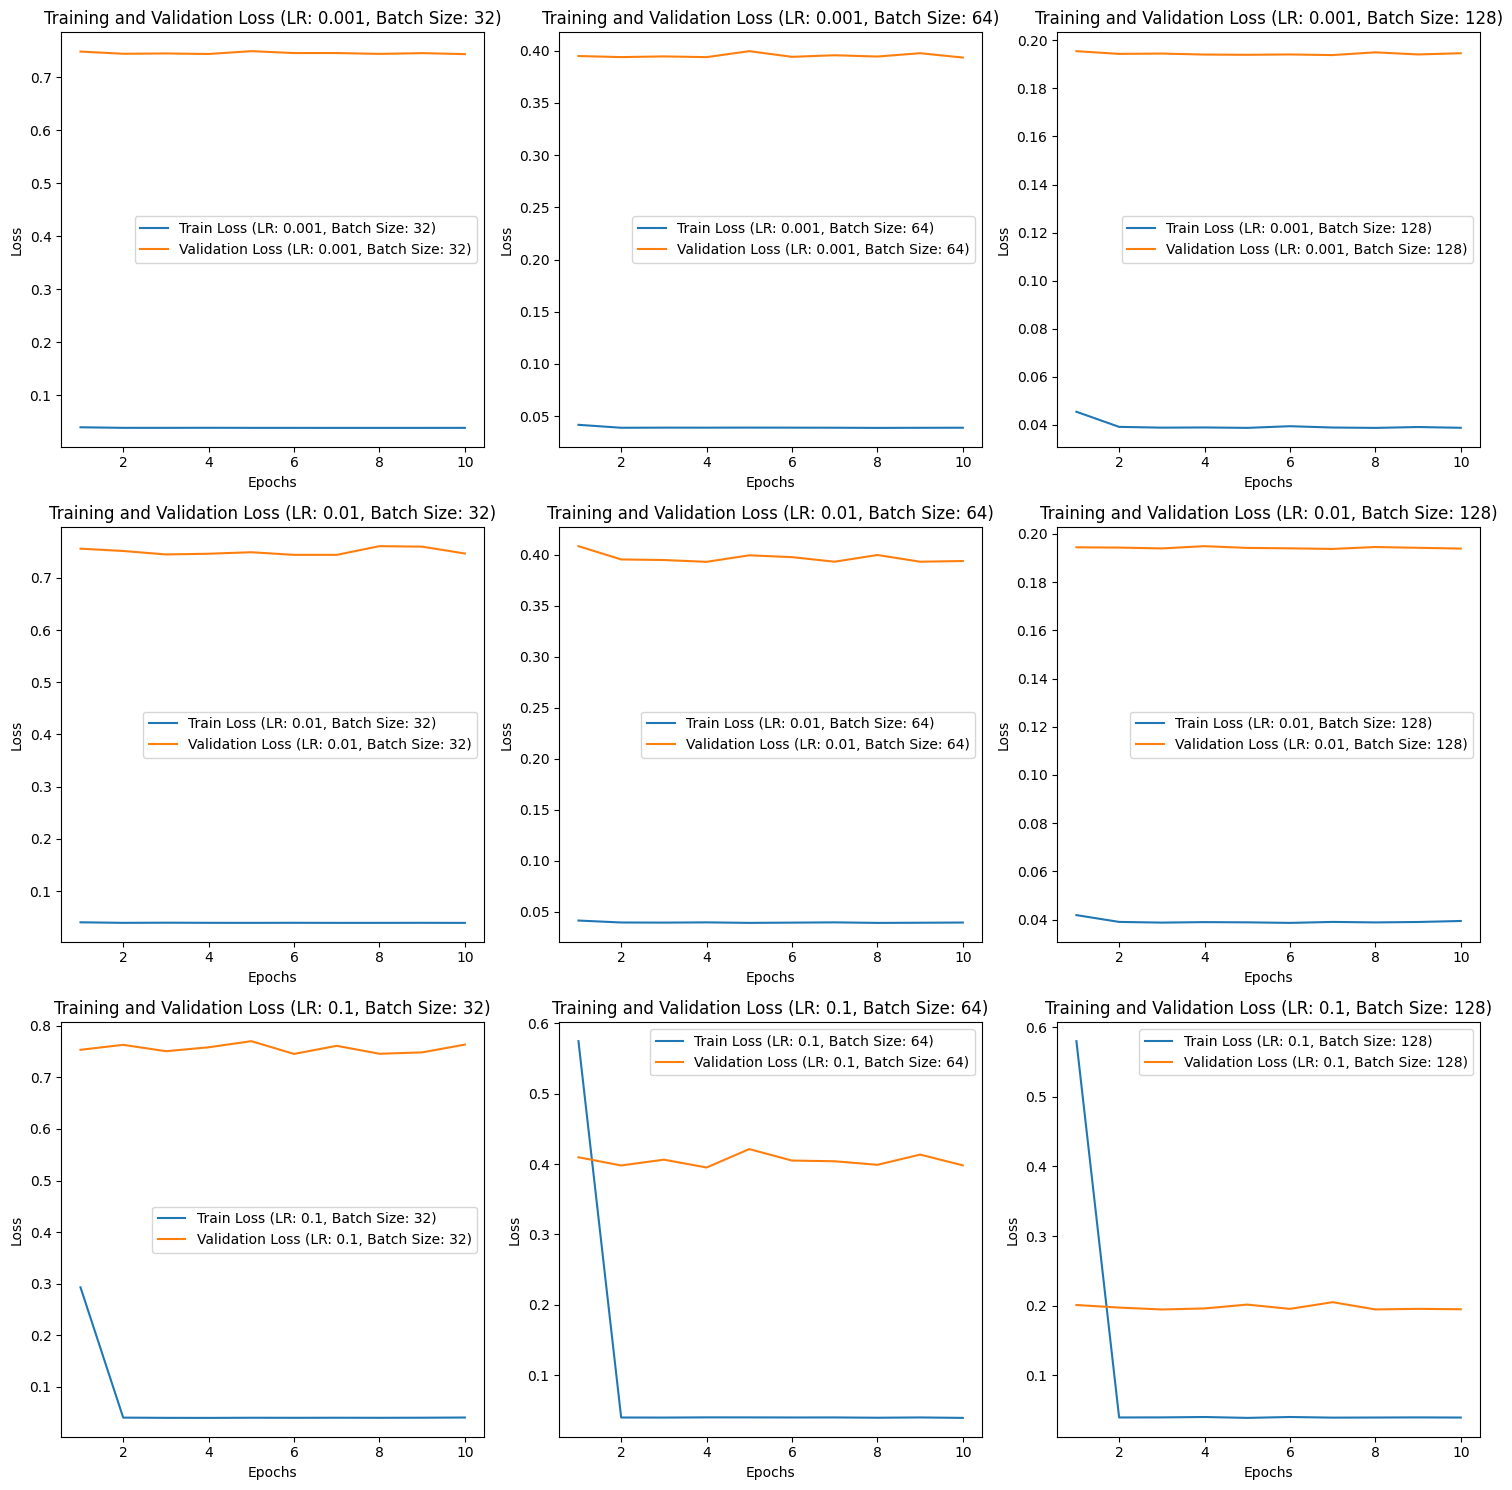

In [113]:
criterion = nn.MSELoss()

train_losses = []
val_losses = []
epochs_list = []
input_size = 1 
hidden_size = 64
output_size = 1
epochs = 10
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 64, 128]

fig, axes = plt.subplots(len(learning_rates), len(batch_sizes), figsize=(15, 15))
axes = axes.flatten()
    
for i, lr in enumerate(learning_rates):
    for j, batch_size in enumerate(batch_sizes):
        model = SimpleLSTM(input_size, hidden_size, output_size)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)
        
        print(f"Learning rate: {lr}, batch size: {batch_size}")
        train_losses,val_losses = train_lstm_model(model, train_loader, val_loader, criterion, optimizer, epochs)

        epochs_list = list(range(1, epochs + 1))
        
        plot_loss_history(train_losses, val_losses, epochs_list, lr, batch_size, ax=axes[i * len(batch_sizes) + j])

plt.tight_layout()
plt.show()

Комбинация скорости обучения 0.1 и размера пакета 128 кажется наиболее эффективной, так как она последовательно обеспечивает наименьшие потери на валидации на протяжении эпох.
Более низкие скорости обучения (0.001 и 0.01) не показывают таких хороших результатов в данном случае, и более крупный размеры пакетов (128) в целом превосходит более мелкие (32 и 64).

Тест модели

In [114]:
def test_model(model: nn.Module, test_loader: DataLoader) -> float:
    """
    Tests the model on test data.

    Parameters:
    - model (nn.Module): Model.
    - test_loader (DataLoader): DataLoader for test data.

    Returns:
    - float: Loss value.
    """
    model.eval()
    criterion = nn.MSELoss()
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs.unsqueeze(-1).float())
            loss = criterion(outputs.squeeze(), labels.float())
    return loss.item()
test_loss = test_model(model, DataLoader(TensorDataset(X_test, y_test), batch_size=1))
print(f'Test Loss: {test_loss}')

c:\Users\123\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 0.01566077210009098


В целом потери кажутся не такими большими

Сохранение и загрузка модели

In [115]:
torch.save(model.state_dict(), 'trained_model.pth')

model = SimpleLSTM(input_size, hidden_size, output_size)
model.load_state_dict(torch.load('trained_model.pth'))
model.eval()

SimpleLSTM(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Предсказанные и истинные значения для заданного месяца.

In [120]:
full_data = pd.read_csv("dataset/dataset.csv")
full_data['Date'] = pd.to_datetime(full_data['Date'])

target_month = pd.to_datetime("2003-04")

target_index = (full_data['Date'].dt.to_period('M') == target_month.to_period('M')).idxmax()

with torch.no_grad():
    test_inputs, test_labels = X_test, y_test
    test_outputs = model(test_inputs.unsqueeze(-1).float())

    target_index = min(max(target_index, 0), len(test_outputs) - 1)

    predicted_value = test_outputs[target_index].item()
    true_value = test_labels[target_index].item()

    print(f'Predicted Value for {target_month}: {predicted_value}')
    print(f'True Value for {target_month}: {true_value}')

Predicted Value for 2003-04-01 00:00:00: 0.19782602787017822
True Value for 2003-04-01 00:00:00: 0.07268302142620087
